In [61]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [130]:
def opti_fixedT(m_l=0.5, k=3000, tau_max=0.05, omega_max=3000, t=0.2, ics=(0,0,0), guess=(0.0003, 5)):
    m_l = 0.5 #mass to push off ground
    k = 3000 #spring stiffness
    tau_max = 0.05 #N*m stall torque
    omega_max = 3000 #about 10,000rpm free speed

    t = 0.2

    opti = Opti()
    T1 = opti.variable()
    T2 = opti.variable()

    x_a0 = opti.parameter()
    opti.set_value(x_a0, ics[0])
    x_l0 = opti.parameter()
    opti.set_value(x_l0, ics[0])
    v_l0 = opti.parameter()
    opti.set_value(v_l0, ics[0])

    x0 = 1/T2
    x1 = T2**2
    x2 = omega_max**2
    x3 = x1*x2
    x4 = k**2
    x5 = m_l**2
    x6 = T1**4*x5
    x7 = x4*x6
    x9 = 1/tau_max
    x10 = (1/2)*x9
    x12 = T1**2
    x13 = omega_max*t
    x14 = k*x10*x12*x13
    x15 = exp(x14)
    x16 = tau_max*x15
    x17 = x16*x_a0
    x18 = T1*omega_max
    x19 = T2*m_l*v_l0*x18
    x20 = m_l*x12
    x21 = x20*x3
    x22 = k*m_l
    x23 = 2*tau_max
    x24 = x23*x_l0
    x25 = x12*x22
    x26 = x23*x_a0
    x27 = T2*omega_max
    x28 = T2**3
    x29 = omega_max**3
    x30 = T1**3
    x32 = exp(-x14)
    x33 = x32*x9
    x34 = x1*x18
    x35 = T2*v_l0 - x34
    x36 = 2*k
    x37 = T1*T2
    x38 = omega_max*x1
    x39 = 2*v_l0*x25*x38
    x40 = x2*x28
    x41 = x22*x30*x40
    x42 = 2*x41
    x43 = tau_max*x36
    x44 = -x37*x43*x_a0 + x43*x_l0

    r = 4*k*m_l*tau_max**2 - x3*x7
    R_ad_re = if_else(r>0, sqrt(r), 0)
    R_ad_im = if_else(r>0, 0, sqrt(-r))

    x11_re = t*x0*x10*R_ad_re/m_l
    x11_im = t*x0*x10*R_ad_im/m_l

    C_os = cos(x11_re)*cosh(x11_im)
    S_in_re = sin(x11_re)*cosh(x11_im)
    S_in_im = cos(x11_re)*sinh(x11_im)

    SdR = (S_in_re*R_ad_re + S_in_im*R_ad_im) / (R_ad_re**2 + R_ad_im**2) # S_in/R_ad should be purely real (aka x31)
    SmR = S_in_re*R_ad_re - S_in_im*R_ad_im  # S_in*R_ad should be purely real

    x_a = x33*(C_os*(-x19 + x21) + x13*x16 + x15*x19 - x15*x21 + x17 + SdR*(-k*v_l0*x3*x30*x5 + k*x28*x29*x6 + x18*x22*x24 - x25*x26*x27))
    x_l = (1/2)*x33*(C_os*(-x39 + x42 + x44) + SmR*x35 + T2*t*x16*x18*x36 + x15*x39 - x15*x42 + x17*x36*x37 + SdR*(T1**5*T2**4*x29*x4*x5 - m_l*x26*x30*x38*x4 - v_l0*x40*x7 + x20*x24*x27*x4))/k
    v_l = x0*x32*(C_os*x35 + x15*x34 + SdR*(k*m_l*omega_max*v_l0*x1*x12 - x41 - x44))

    opti.minimize(-v_l)
    opti.subject_to(opti.bounded(1e-6, T1, 0.001))
    opti.subject_to(opti.bounded(1e-6, T2, 20))
    opti.set_initial(T1, guess[0])
    opti.set_initial(T2, guess[1])

    log = []
    opti.callback(lambda i: log.append((opti.debug.value(T1), opti.debug.value(T2), opti.debug.value(v_l))))

    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    sol = opti.solve()

    return sol, np.array(log), opti, (T1, T2)

sol, log, opti, (T1, T2) = opti_fixedT(guess=(np.random.uniform(1e-6, 0.001), np.random.uniform(1e-6, 20)))
log

array([[2.78609547e-04, 1.29469784e+01, 3.34662696e+00],
       [3.16589406e-04, 1.28522659e+01, 3.28166335e+00],
       [3.02385331e-04, 7.01240241e+00, 4.87878801e+00],
       [3.44104987e-04, 5.58561143e+00, 5.09999928e+00],
       [3.66240309e-04, 5.65935016e+00, 5.06406133e+00],
       [3.68697751e-04, 5.65913464e+00, 5.06005339e+00],
       [3.48119650e-04, 5.25293334e+00, 5.11193712e+00],
       [3.37510845e-04, 5.36879088e+00, 5.11313560e+00],
       [3.38129704e-04, 5.36668258e+00, 5.11311292e+00],
       [3.36865678e-04, 5.36270182e+00, 5.11316389e+00],
       [3.36849954e-04, 5.36283815e+00, 5.11316391e+00],
       [3.36777823e-04, 5.36263434e+00, 5.11316406e+00],
       [3.36777774e-04, 5.36263476e+00, 5.11316406e+00],
       [3.36776878e-04, 5.36263225e+00, 5.11316406e+00],
       [3.36776877e-04, 5.36263225e+00, 5.11316406e+00]])

In [164]:
for i in range(50):
    sol, log, opti, (T1, T2) = opti_fixedT(guess=(np.random.uniform(1e-6, 0.001), np.random.uniform(1e-6, 20)))
    T1s = log[:,0]
    T2s = log[:,1]
    v_ls = log[:,2]

    radicandT1 = np.linspace(0.0002, 0.001, 50)
    radicandT2 = sqrt(4*k*m_l*tau_max**2 / (radicandT1**4*k**2*m_l**2*omega_max**2))

    plt.clf()
    plt.plot(radicandT1, radicandT2, 'r--', label='radicand=0')
    plt.plot(T1s, T2s, label='casadi evals')
    plt.scatter(opti.debug.value(T1,opti.initial()), opti.debug.value(T2,opti.initial()), label='guess')
    plt.scatter(sol.value(T1), sol.value(T2), label='sol')
    plt.title("Constant transmission ratio optimization")
    plt.xlabel("T1")
    plt.ylabel("T2")
    plt.xlim(0, 0.001)
    plt.ylim(0, 20)
    plt.legend(loc='upper right')
    plt.savefig(f"./plots/{i:04d}.png")

In [168]:
import os, imageio
png_dir = "./plots"

images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(f'{png_dir}/_constantT.gif', images, fps=30, loop=0)

/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_68217/203600317.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


0.0003367768778859344 5.36263224674855 5.11316405814435


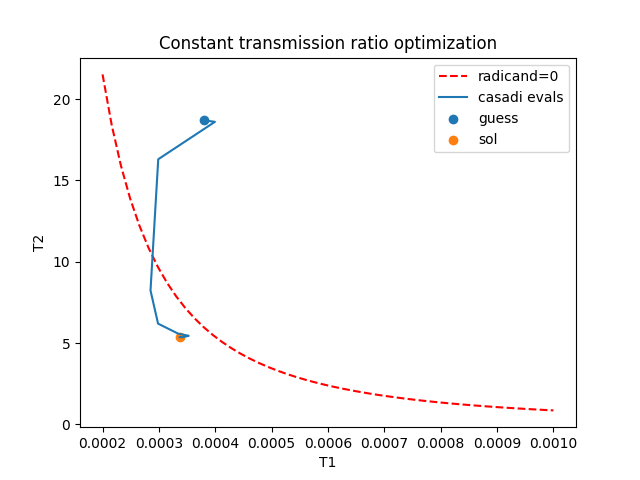

In [84]:
opti.set_initial(T1, np.random.uniform(1e-6, 0.001))
opti.set_initial(T2, np.random.uniform(1e-6, 20))

log = []
opti.callback(lambda i: log.append((opti.debug.value(T1), opti.debug.value(T2), opti.debug.value(v_l))))

opts = {'ipopt.print_level':0, 'print_time':0}

opti.solver('ipopt', opts)
sol = opti.solve()

plt.close('a')

log = np.array(log)
T1s = log[:,0]
T2s = log[:,1]
v_ls = log[:,2]

plt.figure()

initial_T1 = opti.debug.value(T1)


testlog = []
for _T1test in np.linspace(0.0002, 0.001, 50):
    T2_test = sqrt(4*k*m_l*tau_max**2 / (_T1test**4*k**2*m_l**2*omega_max**2))
    testlog.append((_T1test, T2_test))
testlog = np.array(testlog)
plt.plot(testlog[:,0], testlog[:,1], 'r--', label='radicand=0')
plt.plot(T1s, T2s, label='casadi evals')
plt.scatter(opti.debug.value(T1,opti.initial()), opti.debug.value(T2,opti.initial()), label='guess')
plt.scatter(sol.value(T1), sol.value(T2), label='sol')
plt.legend()

plt.title("Constant transmission ratio optimization")

print(sol.value(T1), sol.value(T2), sol.value(v_l))

interactive(children=(IntSlider(value=50, description='dots', min=1), Dropdown(description='colr', options=('r…

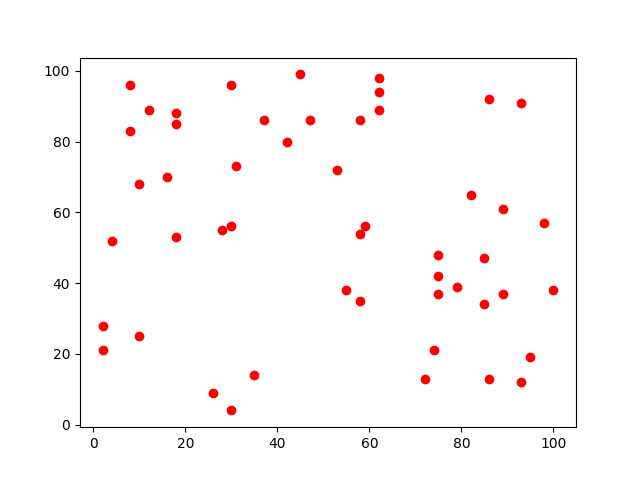

In [105]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

plt.figure()
def series(dots, colr):
    a,b=[],[]
    for i in range(dots):
        a.append(random.randint(1,100))
        b.append(random.randint(1,100))
    plt.scatter(a,b, c=colr)
interact(series, dots=(1,100,1), colr=["red","orange","brown"]);